In [1]:
#from IPython.core.display import clear_output

#!pip3 install pandas-profiling==2.11
#clear_output()

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#! cp /content/drive/MyDrive/semester7/Thesis/Models/* ./ -r
#! cp /content/drive/MyDrive/semester7/Thesis/Datasets/* ./ -r

In [3]:
#!gdown 1YHqgEFHoXa5vpSfKteAhBUWsJJ2RHgS7 -O data.csv

In [4]:
cd D:\Учеба\7 semester\Models_paper

D:\Учеба\7 semester\Models_paper


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
#from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale

from Datasets.ProcessDataset import Dataset

#import torch
from sklearn.model_selection import train_test_split

from Models.Optimisers.GD import StochasticGradientDescent
from Models.Optimisers.Adam import Adam

from Models.Preconditioners.Preconditioners import SGD_preconditioner,Adam_preconditioner,OASIS_preconditioner

#from Models.LogisticRegression.LogisticRegression import Logistic_Regression
#from Models.LogisticRegression.LogisticRegression_layer import Logistic_Regression_train
from Models.LogisticRegression.LogisticRegression_numpy import Logistic_Regression_numpy
from Models.LogisticRegression.LogisticRegression_sklearn import Logistic_Regression_origin

from Models.FederatedLearning.Server import server
from Models.FederatedLearning.Worker import worker

from Models.MatrixScheduler.MatrixScheduler_identical import MatrixScheduler_identical
from Models.MatrixScheduler.MatrixScheduler_Uniform import MatrixScheduler_Uniform,CommonMatrixScheduler_Uniform

from Models.StatisticClass import Statistic
#from Models.StatisticClass import comparsion_array_loss,comparsion_array_weights,comparsion_array_acc
from Models.StatisticClass import array_mean_object, comparsion_array_acc_one_plot,comparsion_array_loss_one_plot

#from Models.StatisticClass import loss_array_mean_plot,acc_array_mean_plot
#from Models.StatisticClass import comparison_loss_array_mean_plot,comparison_acc_array_mean_plot

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression


from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [6]:
import random
random.seed(42)

In [7]:
from tqdm import tqdm

# load Dataset

In [8]:
data = Dataset(dataset_name = 'Titanic')
X,y = data.X,data.y

In [9]:
cd D:\Учеба\7 semester\Models_paper\Reports\3Tuning

D:\Учеба\7 semester\Models_paper\Reports\3Tuning


# Classification Model

In [10]:
#X = d_class
#y = y_class
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#X_train,y_train,X_test,y_test = torch.tensor(X_train),torch.tensor(y_train),torch.tensor(X_test),torch.tensor(y_test)

# Federated learning

### >> Parameters

In [11]:
LR_EPOCH = {'lr': 0.01, 'epoch': 1000}

In [20]:
"""
#n_array = [7,20,70,200,500]
#gamma_array = [0.7,1.8,2,3]
"""


n_array = [7,20]
gamma_array = [0.7,1.8]


In [21]:
#M_NAMES = ["Logistic_Regression_train", "Logistic_Regression","Logistic_Regression_numpy"]
M_NAMES = "Logistic_Regression_numpy"

In [22]:
model_name = M_NAMES#[2]
model_params = {"lr":LR_EPOCH['lr']}
model_name, model_params

('Logistic_Regression_numpy', {'lr': 0.01})

## Example 2 identical

In [23]:
def show_data_stat(stat_collector_array,n_array,gamma_array):
    
    comparsion_array_loss_one_plot(stat_collector_array,n_array,gamma_array)
    comparsion_array_acc_one_plot(stat_collector_array,n_array,gamma_array)

def compare_models(stat_collector_arrays,n_array,gamma_array,n_idx,g_idx):
    print(f"n: {n_array[n_idx]}, gamma: {gamma_array[g_idx]}")
    collectors = []
    idx = n_idx+g_idx*len(n_array)
    for s_c in stat_collector_arrays:
        collectors.append(s_c[idx])
    comparsion_array_loss_one_plot(collectors,n_array = ["model1","model2","model3"],gamma_array= ["model1"])
    comparsion_array_acc_one_plot(collectors,n_array = ["model1","model2","model3"],gamma_array= ["model1"])
    

In [24]:
def tune(run_model,n_array,gamma_array,model_name):
    
    with tqdm(total=len(gamma_array)*len(n_array)) as pbar:
        result = []
        for g in gamma_array:
            for n in n_array:
                current_stat = run_model(gamma = g,n = n)
                result.append(array_mean_object(current_stat,
                                                label = model_name + f"n:{n},gamma:{g}"))
                pbar.update(1)
    return result

### Federated, preconditioner: SGD, matrix: No

In [25]:
#SGD
def sgd_ident_run(gamma,n):
    model_params = {"lr":LR_EPOCH['lr']}

    precond = [SGD_preconditioner(),SGD_preconditioner(),SGD_preconditioner()]

    federated_is_stat_collectors = [Statistic(X_test,y_test,"worker1_ident_sgd"),
                                    Statistic(X_test,y_test,"worker2_ident_sgd"),
                                    Statistic(X_test,y_test,"worker3_ident_sgd")]

    models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[0],
                                           epoch = 1,stat_collector=federated_is_stat_collectors[0]),
             Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[1],
                                           epoch = 1,stat_collector=federated_is_stat_collectors[1]),
             Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[2],
                                           epoch = 1,stat_collector=federated_is_stat_collectors[2])]

    scheduler = [MatrixScheduler_identical(),MatrixScheduler_identical(),MatrixScheduler_identical()]

    s = server(M_workers=3,
               X_train = X_train,y_train = y_train,
               stat_collectors = federated_is_stat_collectors,
               models = models,
               data_splitter = 'id',m_scheduler = scheduler)

    s.run(n_iter=LR_EPOCH['epoch'],T=n)
    
    return federated_is_stat_collectors

In [26]:
r1 = tune(run_model = sgd_ident_run,
     n_array = n_array,
     gamma_array = gamma_array,
     model_name = "no matrix, ")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:58<00:00, 14.64s/it]


#### сравнение: same method, different: n

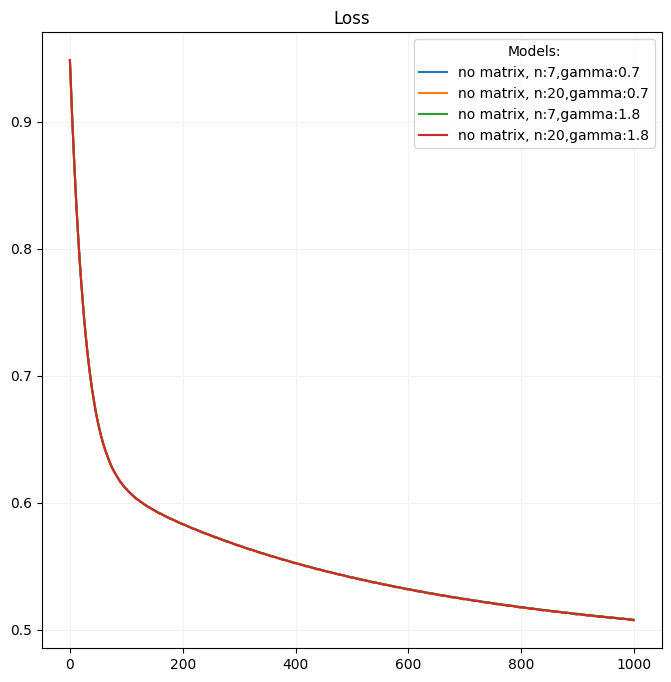

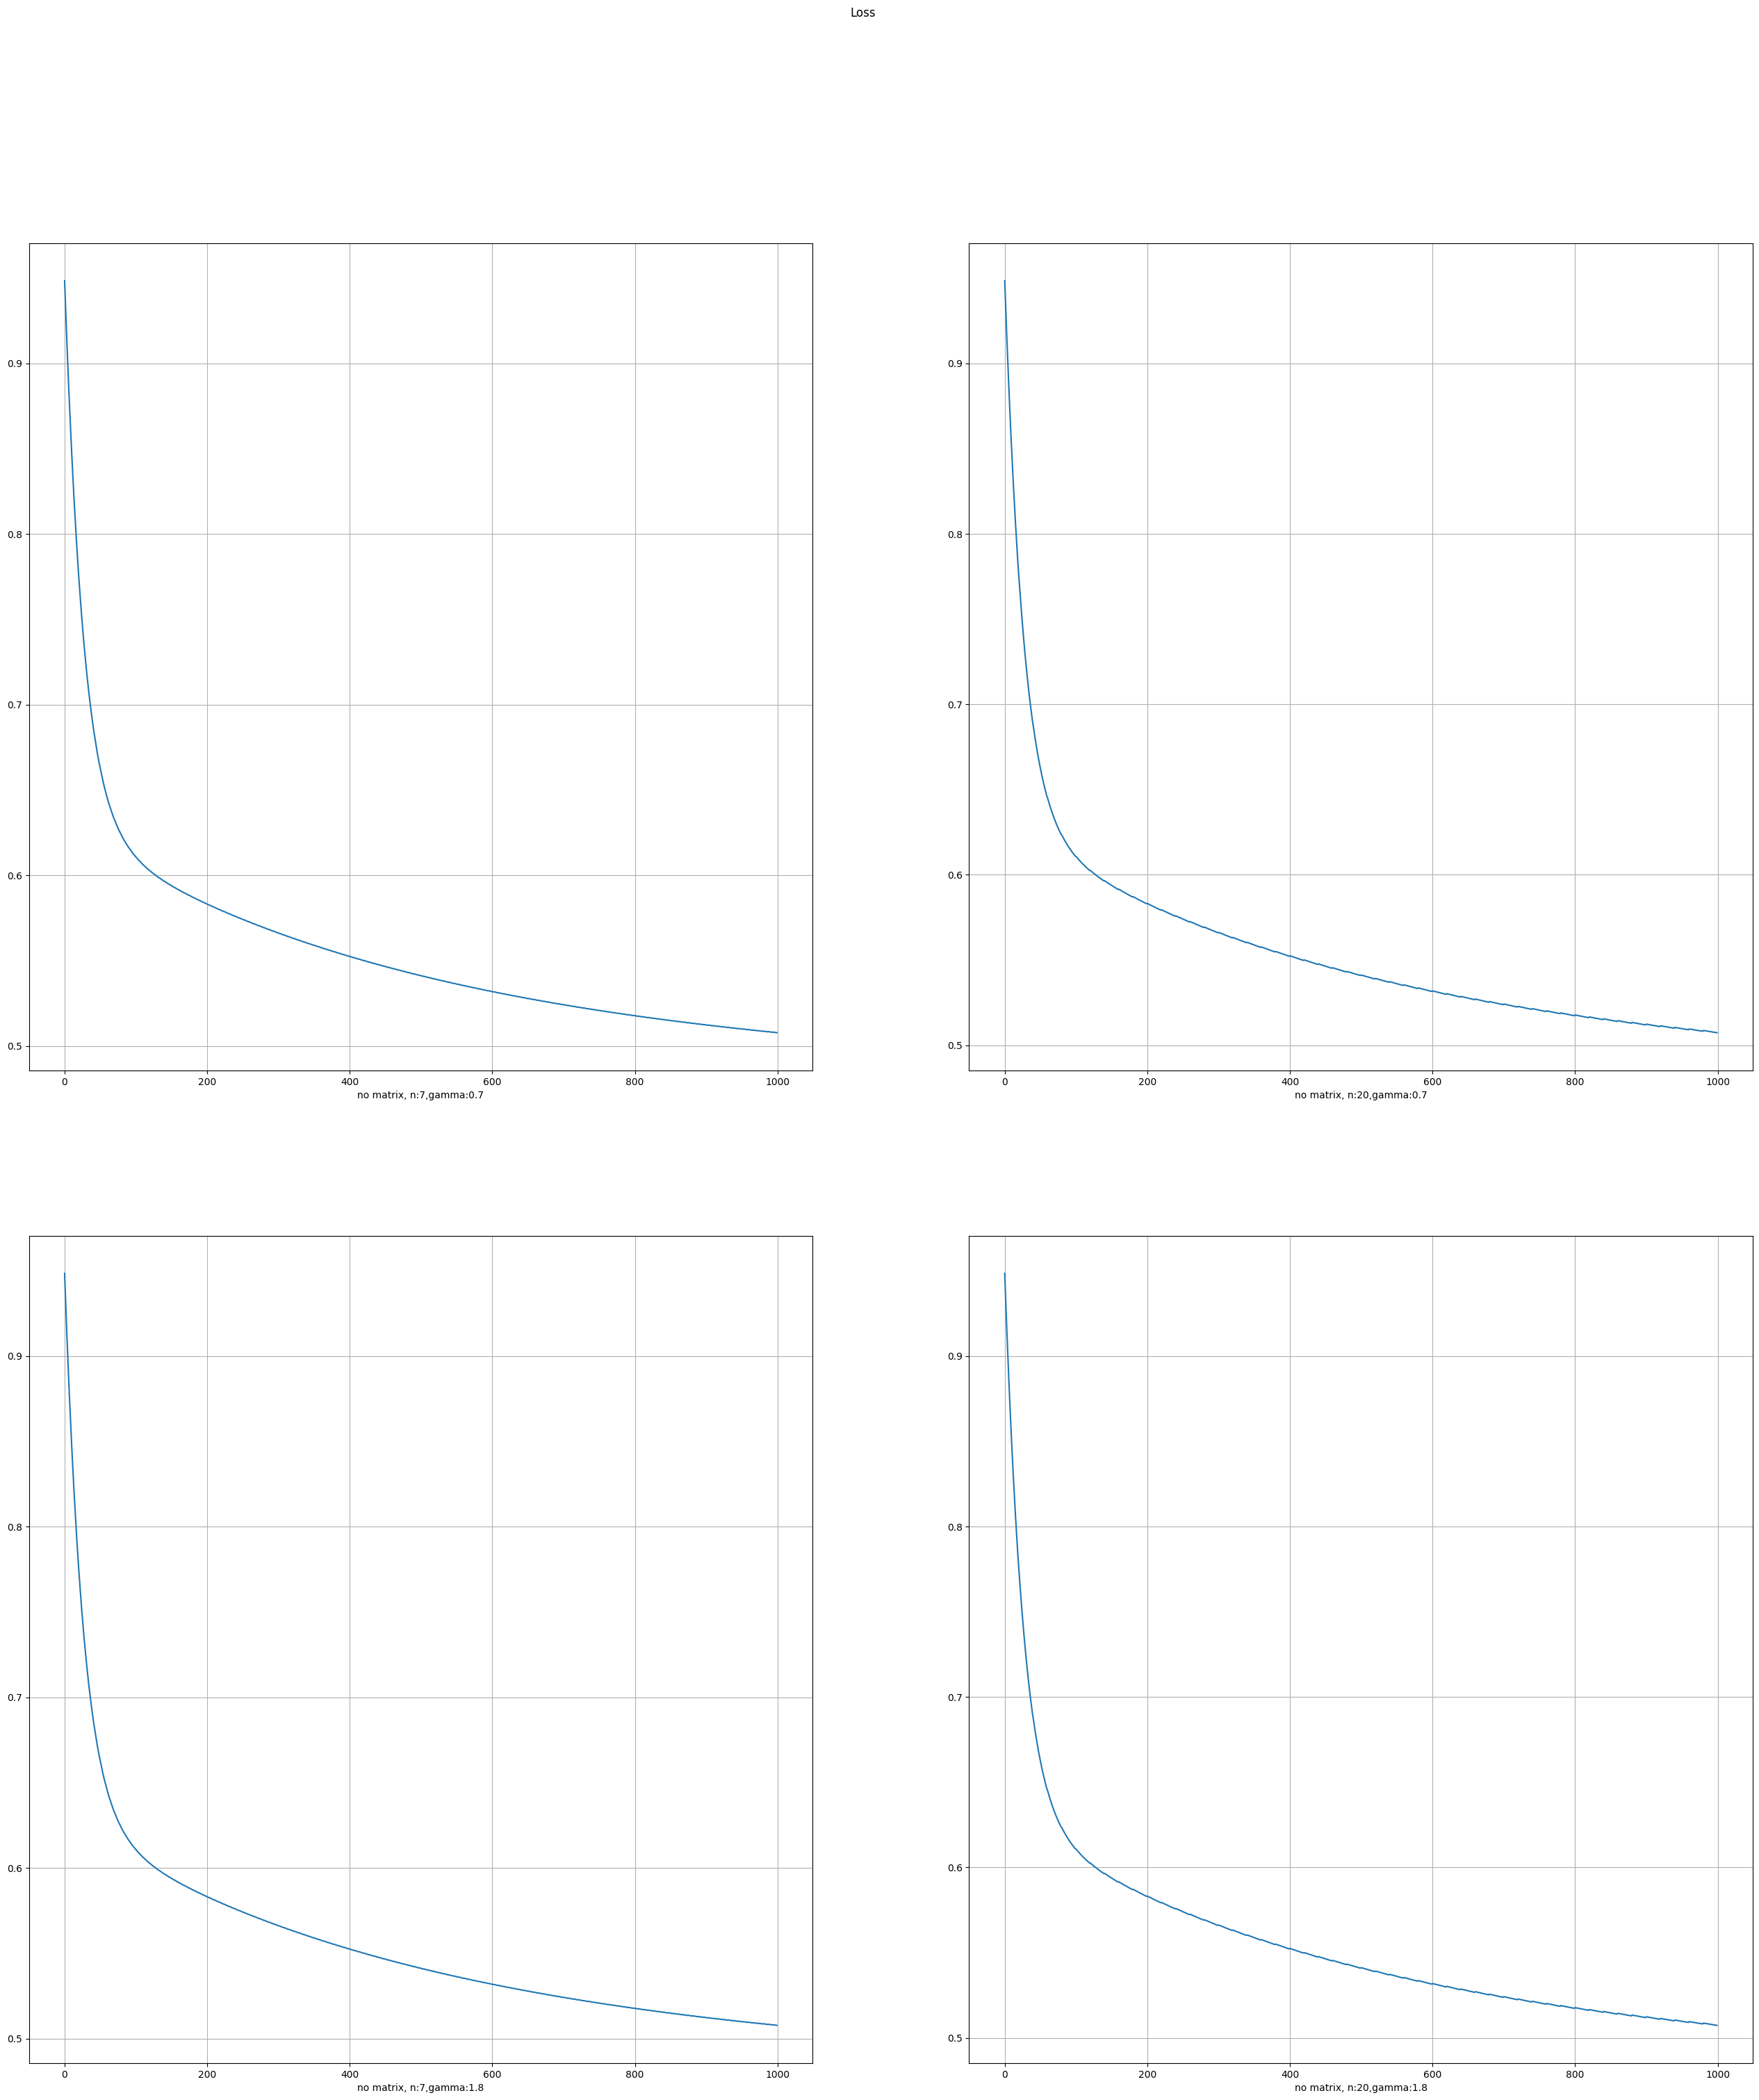

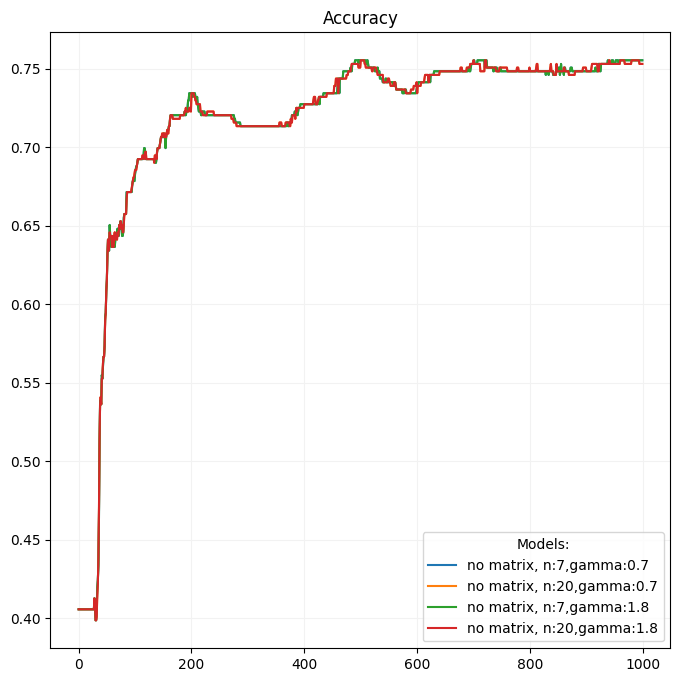

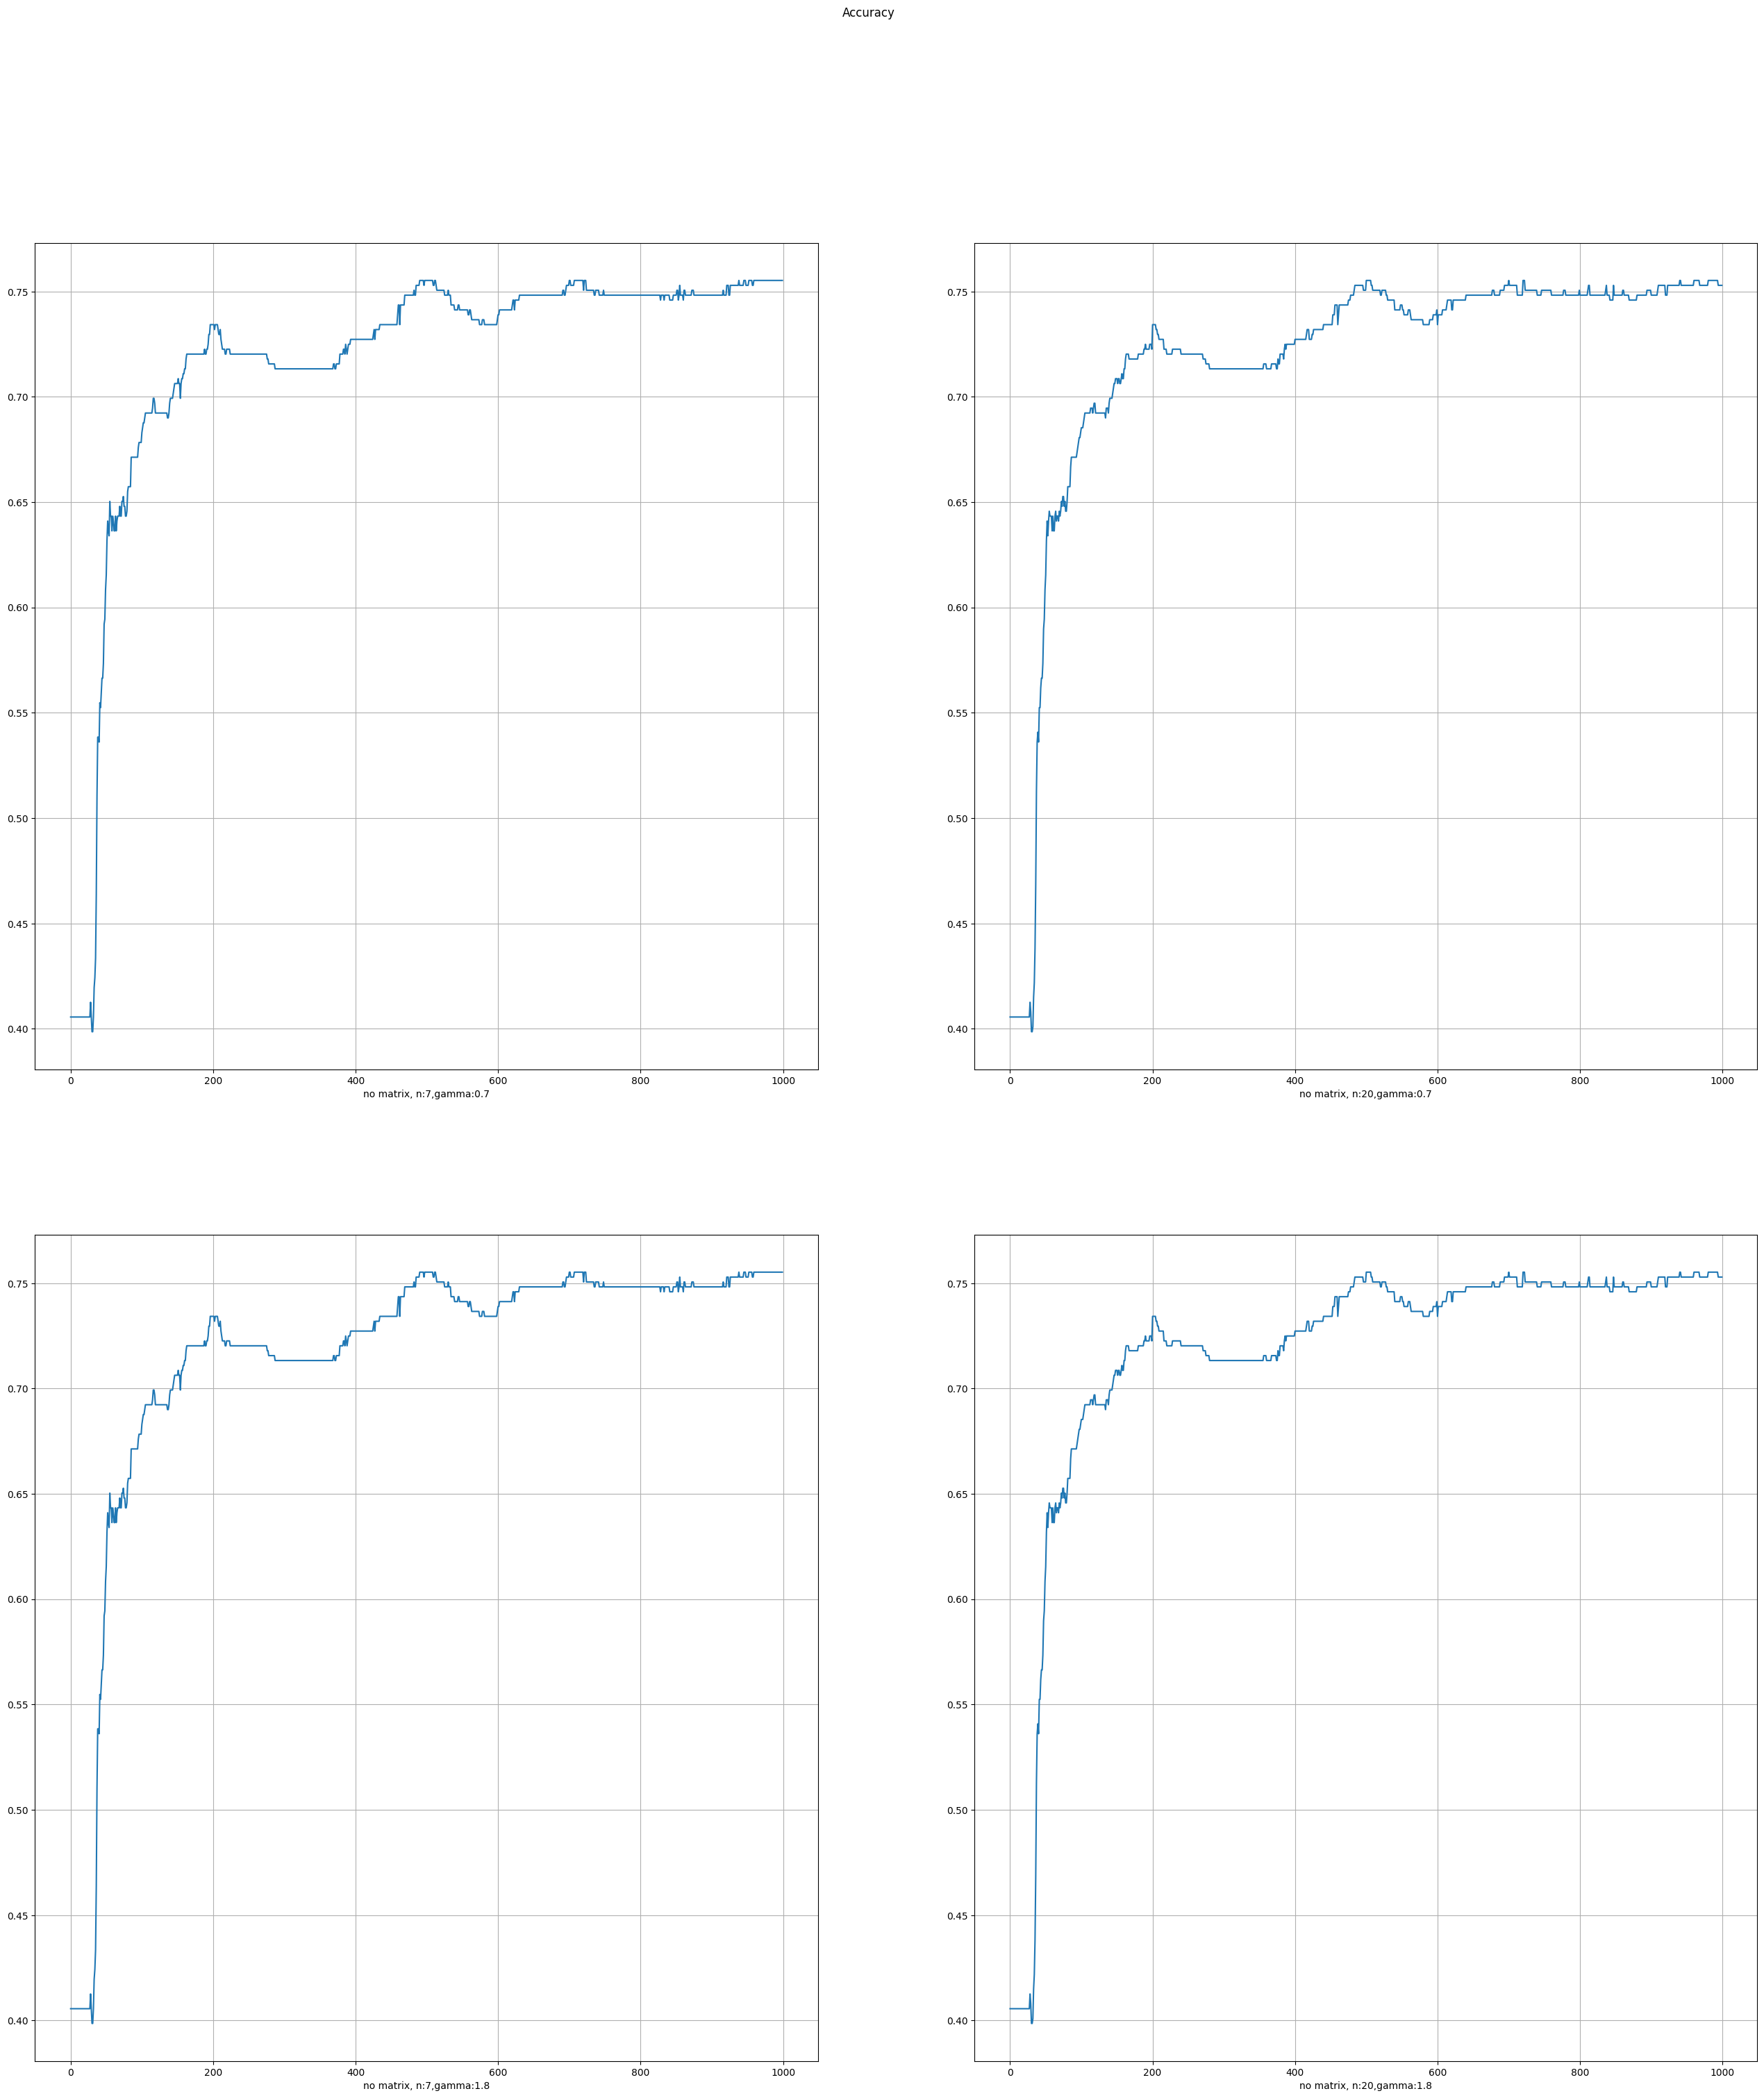

In [27]:
show_data_stat(stat_collector_array = r1,
               n_array = n_array,
               gamma_array = gamma_array)

### Federated, preconditioner: Adam, matrix: uniform

In [ ]:
#SGD
def adam_uniform_run(gamma,n):
    model_params = {"lr":LR_EPOCH['lr']}

    precond = [Adam_preconditioner(beta2 = 0.4),
               Adam_preconditioner(beta2 = 0.4),
               Adam_preconditioner(beta2 = 0.4)]

    federated_ua_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_adam"),
                                    Statistic(X_test,y_test,"worker2_uniform_adam"),
                                    Statistic(X_test,y_test,"worker3_uniform_adam")]

    models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[0],
                                           epoch = 1,stat_collector=federated_ua_stat_collectors[0]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[1],
                                           epoch = 1,stat_collector=federated_ua_stat_collectors[1]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[2],
                                           epoch = 1,stat_collector=federated_ua_stat_collectors[2])]

    scheduler = CommonMatrixScheduler_Uniform(alpha=0.01,gamma=gamma,
                                          change_mode=CommonMatrixScheduler_Uniform.change_on_each_global_update,n_workers = 3)

    schedulers = [scheduler, scheduler, scheduler]

    s = server(M_workers=3,
               X_train = X_train,y_train = y_train,
               stat_collectors = federated_ua_stat_collectors,
               models = models,
               data_splitter = 'id',m_scheduler = schedulers)

    s.run(n_iter=LR_EPOCH['epoch'],T=n)
    
    return federated_ua_stat_collectors

In [ ]:
r2 = tune(run_model = adam_uniform_run,
     n_array = n_array,
     gamma_array = gamma_array,
     model_name = "adam, matrix, ")

#### сравнение: same method, different: n, $\gamma$

In [ ]:
show_data_stat(stat_collector_array = r2,
               n_array = n_array,
               gamma_array = gamma_array)

### Federated, preconditioner: OASIS, matrix: uniform

In [ ]:
#OASIS
def oasis_uniform_run(gamma,n):
    model_params = {"lr":LR_EPOCH['lr']}

    precond = [OASIS_preconditioner(beta2 = 0.2,alpha=1e-4),
               OASIS_preconditioner(beta2 = 0.2,alpha=1e-4),
               OASIS_preconditioner(beta2 = 0.2,alpha=1e-4)]

    federated_uo_stat_collectors = [Statistic(X_test,y_test,"worker1_uniform_oasis"),
                                    Statistic(X_test,y_test,"worker2_uniform_oasis"),
                                    Statistic(X_test,y_test,"worker3_uniform_oasis")]

    models = [Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[0],
                                           epoch = 1,stat_collector=federated_uo_stat_collectors[0]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[1],
                                           epoch = 1,stat_collector=federated_uo_stat_collectors[1]),
              Logistic_Regression_numpy(n_features = X_train.shape[1],optimizer = None,
                                           lr = model_params['lr'], preconditioner = precond[2],
                                           epoch = 1,stat_collector=federated_uo_stat_collectors[2])]

    scheduler = CommonMatrixScheduler_Uniform(alpha=0.01,gamma=gamma,
                                          change_mode=CommonMatrixScheduler_Uniform.change_on_each_global_update,n_workers = 3)

    schedulers = [scheduler, scheduler, scheduler]

    s = server(M_workers=3,
               X_train = X_train,y_train = y_train,
               stat_collectors = federated_uo_stat_collectors,
               models = models,
               data_splitter = 'id',m_scheduler = schedulers)

    s.run(n_iter=LR_EPOCH['epoch'],T=n)
    
    return federated_uo_stat_collectors

In [ ]:
r3 = tune(run_model = oasis_uniform_run,
     n_array = n_array,
     gamma_array = gamma_array,
     model_name = "oasis, matrix, ")

#### сравнение: same method, different: n, $\gamma$

In [ ]:
show_data_stat(stat_collector_array = r3,
               n_array = n_array,
               gamma_array = gamma_array)

### Сравнение 3 методов при одном n, $\gamma$

In [ ]:
n_array,gamma_array

In [ ]:
compare_models([r1,r2,r3],n_array,gamma_array,2,1)